## Imports

In [13]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import sys

# Hacky fix to import from parent directory
path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)

In [15]:
from src.td3_code.agents.td3 import TD3Agent
from src.td3_code.memory.trajectory_replay_buffer import TrajectoryMemoryBuffer
from src.td3_code.memory.transition_replay_buffer import TransitionMemoryBuffer
from src.td3_code.runners.runner import Runner

from src.utils.plot_results import plot_results

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env

## Weights and biases

In [16]:
import wandb

# wandb.init(project="electric-vehicle-charging-rl", entity="electric-vehicle-charging")

## Environment configuration

In [17]:
config = {
    "path_to_data": "./data/",
    "t0_hr": 6.0,  # When the episode start (default value 6AM)
    "dt_min": 30,  # Timestep size
    "ev_dt_min": 60,  # Timestep size for EV arrivals
    "ev_sampling_dt_min": 60,  # How EV sessions are sampled from the data
    "apply_gaussian_noise": False,  # Make data noisy
    "ev_utility_coef_mean": 1,  # Mean value of the utility coefficient for the EVs
    "ev_utility_coef_scale": 0.13,  # STD of the utility coefficient for the EVs
    "days_per_month_train": 20,  # Days per month for training
    "ev_session_months_train": [
        "01",
        # "02",
        # "03",
        # "04",
        # "06",
        # "07",
        # "08",
        # "09",
        # "10",
        # "11",
    ],
    # Months to sample EV sessions for training
    "grid_to_use": "ieee16",  # What grid topology to use. Now supports only IEEE16.
    "ev_session_months_test": ["05", "12"],  # Months to sample EV sessions for test
    "n_ps_pvs": 4,  # Amount of solar panels that use PecanStreet data
    "n_canopy_pvs": 0,  # Amount of solar panels that use canopy data
    "canopy_pv_rated_power": 250,  # Rated power of these panels
    "n_loads": 0,  # Amount of inflexible loads
    "n_feeders": 1,  # Amount of feeders
    "n_ev_chargers": 4,  # Amount of EV chargers
    "ps_pvs_rated_power": 4,  # Rated power of these panels
    "avg_evs_per_day": 3.5,  # Scaling of the EV arrival rate
    "feeder_p_min": -5,  # Capacity of the feeders
    "g": 4,  # Conductance of each line
    "i_max": 25,  # Capacity of each line
    
    # New and improved config options
    "environment_type": "gym",
    "use_constraint_projection": False,
    "use_rescaled_actions": True,
    "normalize_environment_outputs": True,
    "default_episode_index": None,

    "violations_in_reward" : False,
    "one_reward_target" : False,

    "random_epoch_order" : False,
}

# wandb.config.update(config)


## Create environment

In [18]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'use_constraint_projection': False, 'use_rescaled_actions': True, 'normalize_environment_outputs': True, 'default_episode_index': None, 'violations_in_reward': False, 'one_reward_target': False, 'random_epoch_order': False}
loading strait from cache


In [19]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)

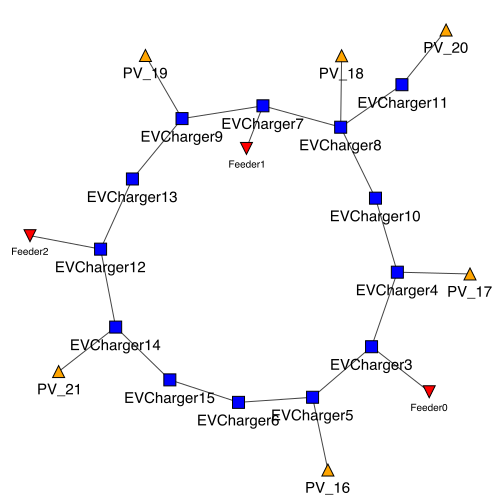

In [20]:
env.plot_grid(bbox=(0, 0, 500, 500))

In [21]:
observation_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]
max_action_value = env.action_space.high[0]
scheme = {'observations': env.observation_space.shape, 
          'observations_next': env.observation_space.shape,
          'actions': env.action_space.shape,
          'done': (1, ), 'reward': (1, ), 'reset_mask': (1, )}

## Configure agent and runner

In [22]:
agent_config = {
    "nlp_width": 7,
    "nlp_length": 4,
    "lstm_width": 6,
    "lstm_length": 1,
    "lstm_dims": [],
    "hidden_dims": [128, 128, 128],
    "actor_lr": 5e-4,
    "critic_lr": 5e-4,
    "discount": 0.99,
    "tau": 0.005,
    "policy_noise": 0.1,
    "noise_clip": 0.2,
    "policy_update_freq": 2,
    "batch_size": 16,
    "min_size_to_sample": 10,
    "n_eps": 100001,
    "test_each": 50,
    "n_test_episodes": 1,
    "memory": "traj", # traj, traj_trans, trans. traj seems the most promising
}

# wandb.config.update(agent_config)

In [23]:
def create_runner(config):
    memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=config['min_size_to_sample'],
                                              use_transitions=True, sample_during_episode=True)

    memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=config['min_size_to_sample'],
                                          sample_during_episode=True)


    memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=config['min_size_to_sample'],
                                         use_transitions=False, sample_during_episode=False)

    agent = TD3Agent(observation_dim, action_dim, 1, config['lstm_dims'], config['hidden_dims'],
                     actor_lr=config['actor_lr'], critic_lr=config['critic_lr'],  discount=config['discount'], tau=config['tau'],
                     policy_noise=config['policy_noise'], noise_clip=config['noise_clip'], policy_update_freq=config['policy_update_freq'])

    # Can choose which of the buffers to use by changing the second argument
    if agent_config['memory'] == 'traj':
        runner = Runner(env, memory_traj, agent, config['default_episode_index'])
    elif agent_config['memory'] == 'traj_trans':
        runner = Runner(env, memory_traj_trans, agent, config['default_episode_index'])
    elif agent_config['memory'] == 'trans':
        runner = Runner(env, memory_trans, agent, config['default_episode_index'])

    return runner

## Train

In [24]:
def train():
    with wandb.init(project="electric-vehicle-charging-rl", entity="electric-vehicle-charging", config={**agent_config, **config}) as run:
        # Recalculate the hidden dims and lstm dims
        nlp_width = wandb.config["nlp_width"]
        nlp_length = wandb.config["nlp_length"]
        lstm_width = wandb.config["lstm_width"]
        lstm_length = wandb.config["lstm_length"]
        dims = {
            "hidden_dims" : [2**nlp_width for _ in range(nlp_length)],
            "lstm_dims" : [2**lstm_width for _ in range(lstm_length)]
        }

        wandb.config.update(dims)

        wandbconfig = wandb.config
        runner = create_runner(wandbconfig)

        batch_size = wandbconfig['batch_size']

        n_eps = wandbconfig['n_eps']
        print_each = 50
        test_each = wandbconfig['test_each']
        n_test_episodes = wandbconfig['n_test_episodes']

        keys_to_print = ['reward', 'greedy_reward', 'deterministic_reward', 'max_reward']

        train_results = defaultdict(list)
        test_results = defaultdict(list)

        for ep in range(1, n_eps):
            episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)

            for key, val in episode_results.items():
                train_results[key].append(val)
                wandb.log({f"train_{key}": val, "epoch":ep})

            if ep % print_each == 0:
                print('Training episode %d    ' % ep)

                for key in keys_to_print:
                    if key in train_results:
                        print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))

                print()

            if ep % test_each == 0:
                current_test_results = defaultdict(list)

                for test_ep in range(n_test_episodes):
                    episode_results = runner.run(train=False, save_to_memory=False)

                    for key, val in episode_results.items():
                        current_test_results[key].append(val)

                current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}

                for key, val in current_test_results.items():
                    test_results[key].append(val)
                    wandb.log({f"test_{key}": val, "epoch":ep})

                print('Test run after episode %d:' % ep)

                for key in keys_to_print:
                    if key in current_test_results:
                        print('    %s=%.2f' % (key, current_test_results[key]))

                print()

In [25]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning) # make the

train()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fransdb (electric-vehicle-charging). Use `wandb login --relogin` to force relogin
/Users/fransdeboer/Projects/RL-EVCP/venv/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:47: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


Training episode 50    
    reward=290.70

Test run after episode 50:
    reward=192.59
    greedy_reward=212.51
    deterministic_reward=213.93
    max_reward=216.39

Training episode 100    
    reward=250.45

Test run after episode 100:
    reward=292.05
    greedy_reward=304.56
    deterministic_reward=344.68
    max_reward=420.33

Training episode 150    
    reward=220.49

Test run after episode 150:
    reward=191.32
    greedy_reward=301.19
    deterministic_reward=304.11
    max_reward=308.80

Training episode 200    
    reward=263.98

Test run after episode 200:
    reward=144.15
    greedy_reward=162.08
    deterministic_reward=176.86
    max_reward=180.13

Training episode 250    
    reward=218.85

Test run after episode 250:
    reward=148.39
    greedy_reward=419.09
    deterministic_reward=421.55
    max_reward=494.16

Training episode 300    
    reward=125.36

Test run after episode 300:
    reward=90.54
    greedy_reward=319.24
    deterministic_reward=335.58
    ma

/Users/fransdeboer/Projects/RL-EVCP/venv/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:47: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_bare_reward,█▆▇▁▃▂▃▃▄▄▄▇▃▃▇▃▄▂▅▂▃▅▅▅▄▄▃▃▃▂▃▄▄▇▄▃▇▄▅▃
test_deterministic_reward,█▃▃▁▅▁▅▄▅▆▄▅▄▄▅▅▇▃▇▅▃▄▅█▄▆▆▄▄▁▇▅▅▅▄▄▇▅▇▃
test_env_time,█▂▃▄▂▂▂▄▂▂▂▂▂▅▃▃▁▂▃▂▂▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
test_greedy_reward,█▂▂▁▄▁▅▄▅▅▄▅▃▃▆▄▇▃▅▆▂▄▄█▃▆▅▃▃▁▇▅▄▅▄▃▇▃▇▃
test_length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_max_reward,▆▃▃▁▄▁▄▃▄▅▅▆▃▃▇▄▆▂▅▆▂▃▅█▃▆▄▃▃▁▅▅▄▆▃▃▇▄▆▃
test_reward,█▆▇▁▃▂▃▃▄▄▄▇▃▃▇▃▄▂▅▂▃▅▅▅▄▄▃▃▃▂▃▄▄▇▄▃▇▄▅▃
test_sampling_time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_total_evs_social_welfare,█▆▇▁▃▂▃▃▄▄▄▆▃▃▇▃▃▂▅▂▃▅▅▅▄▄▃▃▃▂▃▄▄▆▄▃▇▃▅▃
test_total_feeders_power_price,▁▃█▂████████████████████████████████████


KeyboardInterrupt: 

### Run a wandb parameter sweep to find the best performing hyperparpameters

see https://docs.wandb.ai/guides/sweeps/quickstart

In [ ]:
sweep_config = {
  "name" : "my-test-sweep",
  "method" : "bayes",
  "metric" : {
      "name" : "test_reward",
      "goal" : "maximize"
  },
  "parameters" : {
    "nlp_width" : {
        "min" : 5,
        "max" : 9,
    },
    "nlp_length" : {
        "min" : 2,
        "max" : 6,
    },
    "lstm_width" : {
        "min" : 2,
        "max" : 7,
    },
    "lstm_length" : {
        "min" : 0,
        "max" : 5,
    },
    "policy_update_freq" : {
        "values" : [1, 2, 3, 4]
    },
    "actor_lr" : {
        "min" : 8e-6,
        "max" : 8e-4,
    },
    "critic_lr" : {
        "min" : 8e-6,
        "max" : 8e-4,
    },
    "discount" : {
        "min" : 0.9,
        "max" : 0.999,
    },
    "tau" : {
        "min" : 0.001,
        "max" : 0.01,
    },
    "policy_noise": {
        "min" : 0.04,
        "max" : 0.5,
    },
  }
}

sweep_id = wandb.sweep(sweep_config, project="electric-vehicle-charging-rl", entity="electric-vehicle-charging")

In [ ]:
manual_id = "dm3gga2x"

count = 1 # number of runs to execute
wandb.agent(manual_id, function=train, count=count, project="electric-vehicle-charging-rl", entity="electric-vehicle-charging")


## Plot results locally

In [ ]:
plt.plot(test_results['reward'])

In [ ]:
episode_results, final_results_list = runner.run(train=False, save_to_memory=False, final=True)

print('Reward = %.2f' % episode_results['reward'])
plot_results(env, final_results_list, figsize=(12, 7))

In [ ]:
wandb.log({"constraints_violation" : wandb.plot.line_series(
          xs=list(range(len(env.timesteps_str[:-1]))),
          ys=[[res['i_constraints_violation'] for res in final_results_list],
          [res['power_flow_constraints_violation'] for res in final_results_list]],
          keys=["I violation", "P violation"],
          title="Constraint violations",
          xname="Time")})

In [ ]:
rewards = [res['reward'] for res in final_results_list]
feeders_price = [res['feeders_power_price'] for res in final_results_list]
pvs_price = [res['pvs_power_price'] for res in final_results_list]
evs_welfare = [res['evs_social_welfare'] for res in final_results_list]

wandb.log({"objective" : wandb.plot.line_series(
          xs=list(range(len(env.timesteps_str[:-1]))),
          ys=[rewards, feeders_price, pvs_price, evs_welfare],
          keys=["Total reward", "Feeders price", "PVs price", "EVs welfare"],
          title="Objective",
          xname="Time")})